Example coming from here: https://www.tensorflow.org/tutorials/generative/cvae?hl=fr

In [6]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time


Chaque image MNIST est à l'origine un vecteur de 784 nombres entiers, dont chacun est compris entre 0 et 255 et représente l'intensité d'un pixel. Modélisez chaque pixel avec une distribution de Bernoulli dans notre modèle et binarisez statiquement l'ensemble de données.

In [7]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 1s 0us/step


In [9]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)
train_size = 60000
batch_size = 32
test_size = 10000


## Utilisez tf.data pour regrouper et mélanger les données

In [10]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## Définissez les réseaux d'encodeur et de décodeur avec tf.keras.Sequential

Dans cet exemple de VAE, utilisez deux petits ConvNets pour les réseaux d'encodeur et de décodeur. 

Dans la littérature, ces réseaux sont également appelés respectivement modèles d'inférence/reconnaissance et modèles génératifs.

Utilisez tf.keras.Sequential pour simplifier la mise en œuvre. Soit et respectivement l'observation et la variable latente dans les descriptions suivantes.

### Réseau codeur

Cela définit la distribution postérieure approximative , qui prend en entrée une observation et produit un ensemble de paramètres pour spécifier la distribution conditionnelle de la représentation latente 
. Dans cet exemple, modélisez simplement la distribution sous la forme d'une gaussienne diagonale, et le réseau génère les paramètres de moyenne et de log-variance d'une gaussienne factorisée. Sortie log-variance au lieu de la variance directement pour la stabilité numérique.

### Réseau décodeur

Ceci définit la distribution conditionnelle de l'observation , qui prend un échantillon latent comme entrée et produit les paramètres pour une distribution conditionnelle de l'observation. Modélisez la distribution latente a priori 
comme une unité gaussienne.

### Astuce de reparamétrage
Pour générer un échantillon pour le décodeur pendant l'apprentissage, vous pouvez échantillonner à partir de la distribution latente définie par les paramètres émis par l'encodeur, étant donné une observation d'entrée 
. Cependant, cette opération d'échantillonnage crée un goulot d'étranglement car la rétropropagation ne peut pas passer par un nœud aléatoire.
Pour résoudre ce problème, utilisez une astuce de reparamétrisation. Dans notre exemple, vous approximez 
en utilisant les paramètres du décodeur et un autre paramètre 
comme suit :
où 
et représentent respectivement la moyenne et l'écart type d'une distribution gaussienne. Ils peuvent être dérivés de la sortie du décodeur. Le peut être considéré comme un bruit aléatoire utilisé pour maintenir la stochasticité du . Générez 
à partir d'une distribution normale standard.
La variable latente 
est maintenant générée par une fonction de , et , ce qui permettrait au modèle de rétropropager les gradients dans l'encodeur via et respectivement, tout en maintenant la stochasticité via 
.

### Architecture de réseau

Pour le réseau de codeurs, utilisez deux couches convolutionnelles suivies d'une couche entièrement connectée. Dans le réseau de décodeurs, reproduisez cette architecture en utilisant une couche entièrement connectée suivie de trois couches de transposition de convolution (alias couches déconvolutives dans certains contextes). Notez qu'il est courant d'éviter d'utiliser la normalisation par lots lors de la formation des VAE, car la stochasticité supplémentaire due à l'utilisation de mini-lots peut aggraver l'instabilité en plus de la stochasticité de l'échantillonnage.


In [11]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

## Définir la fonction de perte et l'optimiseur

Les VAE s'entraînent en maximisant la borne inférieure de la preuve (ELBO) sur la log-vraisemblance marginale :
En pratique, optimisez l'estimation de Monte Carlo à échantillon unique de cette espérance :
où 
est échantillonné à partir de 
.

**Remarque** : Vous pouvez également calculer analytiquement le terme KL, mais ici vous intégrez les trois termes dans l'estimateur de Monte Carlo pour plus de simplicité.

In [12]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [16]:
help(model.reparameterize)

Help on method reparameterize in module __main__:

reparameterize(mean, logvar) method of __main__.CVAE instance



## Entraînement
  Commencez par itérer sur le jeu de données
  Au cours de chaque itération, passez l'image à l'encodeur pour obtenir un ensemble de paramètres de moyenne et de log-variance de l'espace réservé postérieur approximatif 
    puis appliquez l' astuce de reparamétrisation pour échantillonner à partir de 
    Enfin, passez les échantillons reparamétrés au décodeur pour obtenir les logits de la distribution générative 


Remarque : Étant donné que vous utilisez l'ensemble de données chargé par keras avec 60 000 points de données dans l'ensemble d'apprentissage et 10 000 points de données dans l'ensemble de test, notre résultat ELBO sur l'ensemble de test est légèrement supérieur aux résultats rapportés dans la littérature qui utilise la binarisation dynamique du MNIST de Larochelle.
Génération d'images
  Après la formation, il est temps de générer des images
  Commencez par échantillonner un ensemble de vecteurs latents à partir de la distribution a priori gaussienne unitaire 
    Le générateur convertira ensuite l'échantillon latent en logits de l'observation, donnant une distribution 


Ici, tracez les probabilités des distributions de Bernoulli


Epoch: 10, Test set ELBO: -155.53880310058594, time elapse for current epoch: 44.813536643981934


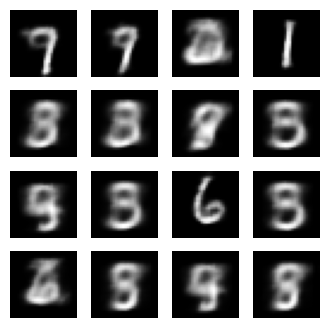

In [13]:
epochs = 10
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 2
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
# Pick a sample of the test set for generating output images
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

(-0.5, 287.5, 287.5, -0.5)

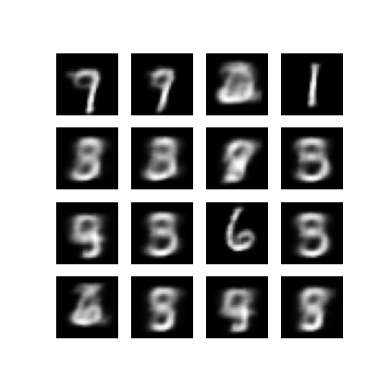

In [14]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
plt.imshow(display_image(epoch))
plt.axis('off')  # Display images
(-0.5, 287.5, 287.5, -0.5)


In [15]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)


/var/folders/dd/2d558xhj27x9cdr0kl8fdtjw0000gp/T/ipykernel_71939/4080911103.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/var/folders/dd/2d558xhj27x9cdr0kl8fdtjw0000gp/T/ipykernel_71939/4080911103.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


ModuleNotFoundError: No module named 'tensorflow_docs'